**Nhóm 1:**
20200025:Đinh Thanh Hà,
20200120:Đặng Quốc Khánh,
20200136:Lê Quốc Bảo,
20200248:Nguyễn Hoàng Linh,
20200309:Bùi Hữu Phúc,
20200336:Nguyễn Phan Thanh Tấn,
20200389:Phạm Văn Trường,

**NOTE:** 3 tập con lần lượt cho train, validation, test nằm trong thư mục nhận diện chữ viết



**Neccessary Import**

In [82]:
# Import necessary packages
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import torch
from torch import nn
import torchvision
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from torch.utils.data import DataLoader, TensorDataset, random_split
from time import time
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

In [83]:
import os


**Download The Dataset & Define The Transforms**

In [84]:
from torchvision import datasets,transforms


# Đường dẫn đến các file
train_path = '/content/drive/MyDrive/hand_written/nhandienchuviet/train.csv/train.csv'
test_path = '/content/drive/MyDrive/hand_written/nhandienchuviet/test.csv/test.csv'
validation_path = '/content/drive/MyDrive/hand_written/nhandienchuviet/train.csv/train.csv'

# Gán dữ liệu và nhãn từ các file
train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)
validation_data = pd.read_csv(validation_path)


train_labels = torch.tensor(train_data.iloc[:, 0].values)
train_images = torch.tensor(train_data.iloc[:, 1:].values).float() / 255.0  # Chuẩn hóa
train_images = train_images.reshape(-1, 1, 28, 28)  # Reshape để phù hợp với định dạng (Batch, Channels, Height, Width)


test_images = torch.tensor(test_data.values).float() / 255.0
test_images = test_images.reshape(-1, 1, 28, 28)

# Chuẩn hóa và reshape validation data
#validation_labels = torch.tensor(validation_data.iloc[:, 0].values)
#validation_images = torch.tensor(validation_data.iloc[:, 1:].values).float() / 255.0  # Chuẩn hóa
#validation_images = validation_images.reshape(-1, 1, 28, 28)  # Reshape để phù hợp với định dạng (Batch, Channels, Height, Width)

# In ra kích thước để kiểm tra
#print("Train Images Shape:", train_images.shape)  # Mong đợi: [42000, 1, 28, 28]
#print("Test Images Shape:", test_images.shape)  # Mong đợi: [28000, 1, 28, 28]
#print("Validation Images Shape:", validation_images.shape)  # Mong đợi: [8400, 1, 28, 28]

# Tạo TensorDataset với nhãn
train_dataset = TensorDataset(train_images, train_labels)
test_dataset = TensorDataset(test_images)

# Chia dữ liệu thành tập huấn luyện và tập validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

# Tạo DataLoader cho tập huấn luyện và validation
train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)





# In ra kích thước để kiểm tra
print("Kích thước tập huấn luyện:", len(train_subset))
print("Kích thước tập xác thực:", len(val_subset))
print("Kích thước tập kiểm tra:", len(test_dataset))

Kích thước tập huấn luyện: 33600
Kích thước tập xác thực: 8400
Kích thước tập kiểm tra: 28000


**Exploring The Data**

In [85]:
# Lấy dữ liệu
dataiter = iter(train_loader)
images, labels = next(dataiter)

print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


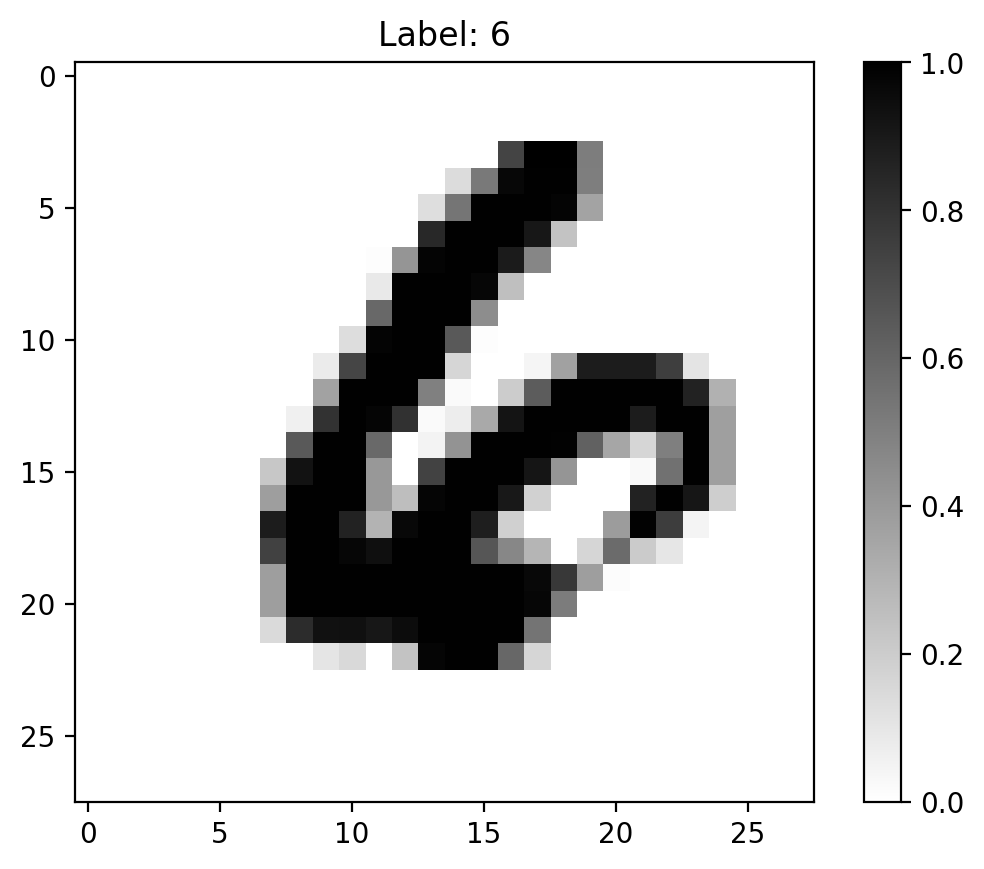

In [86]:
# Hiển thị ảnh đầu tiên và nhãn tương ứng
i = 4 #vi tri thu 4 so voi luoi anh
image = images[i].numpy().squeeze()
label = labels[i].item()
plt.imshow(image, cmap='gray_r')
plt.title(f'Label: {label}')
plt.colorbar()
plt.show()

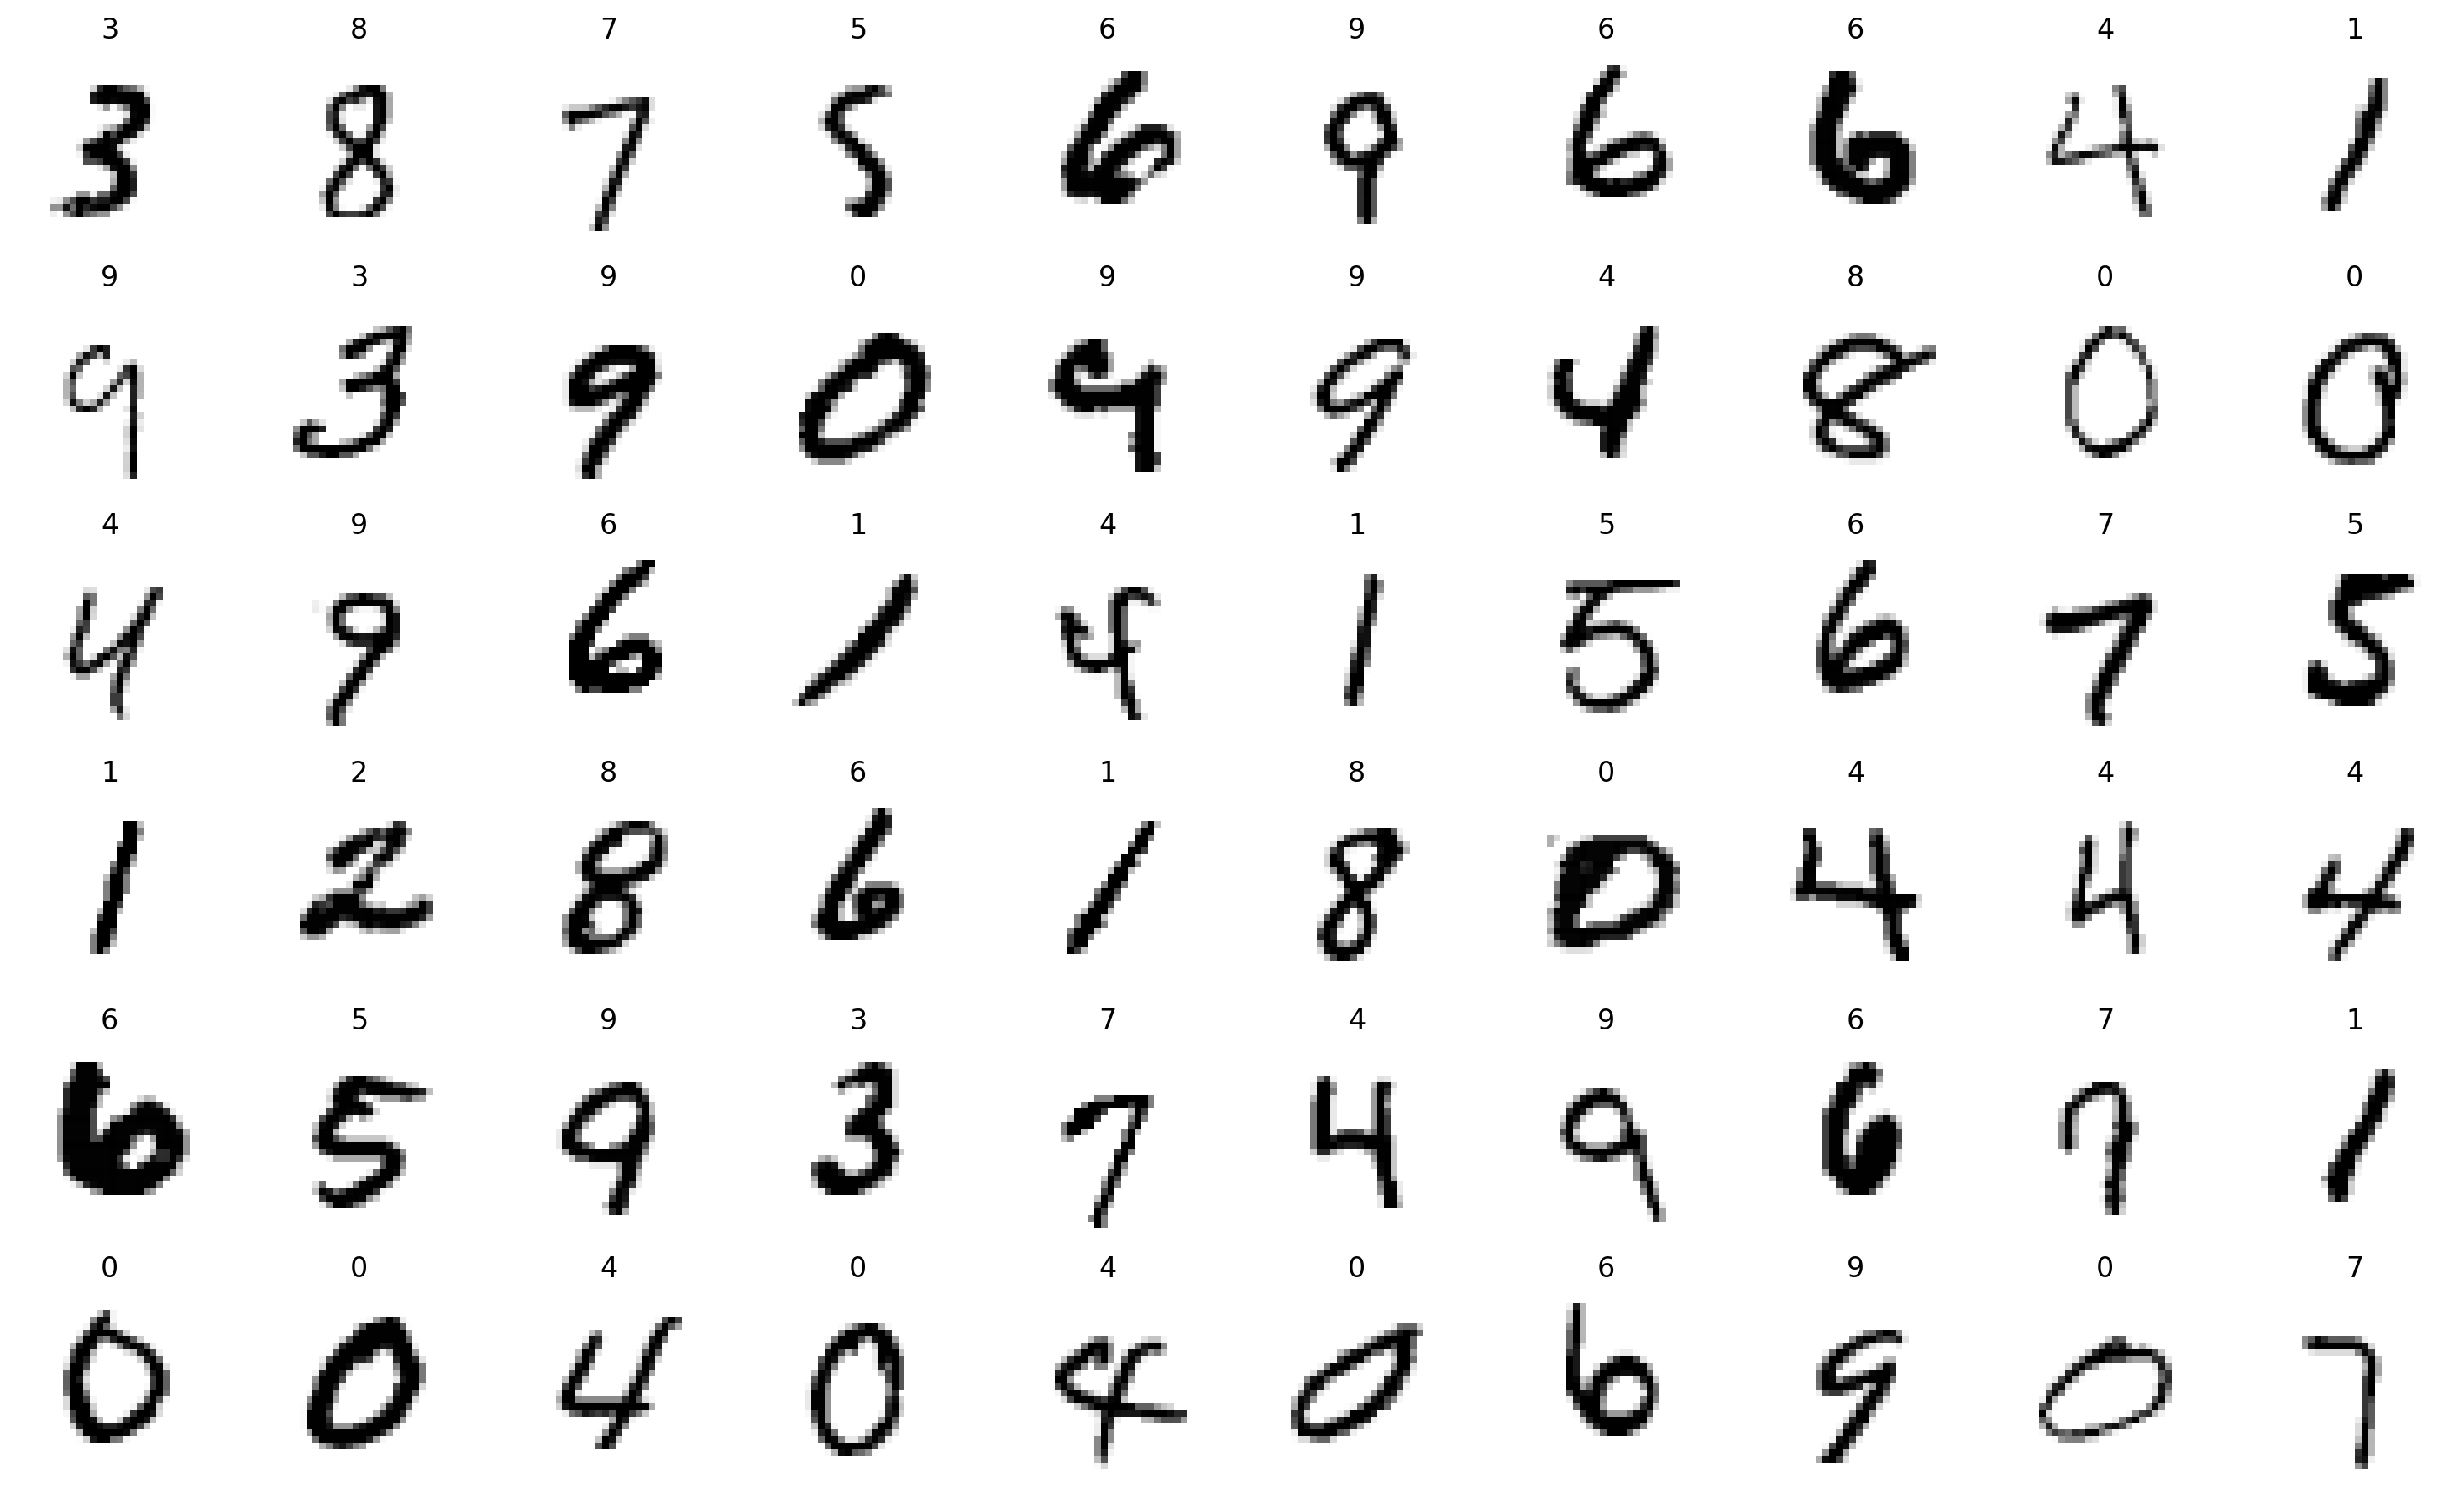

In [87]:
# Hiển thị lưới ảnh
figure, axes = plt.subplots(6, 10, figsize=(15, 9))  # Cấu hình subplot với kích thước phù hợp
axes = axes.flatten()  # Làm phẳng mảng axes để dễ vòng lặp
for idx, ax in enumerate(axes):
    if idx < len(images):  # Kiểm tra để tránh IndexError nếu số ảnh ít hơn 60
        image = images[idx].numpy().squeeze()
        ax.imshow(image, cmap='gray_r')
        ax.axis('off')
        ax.set_title(labels[idx].item())
plt.tight_layout()
plt.show()

**Defining The Neural Network**

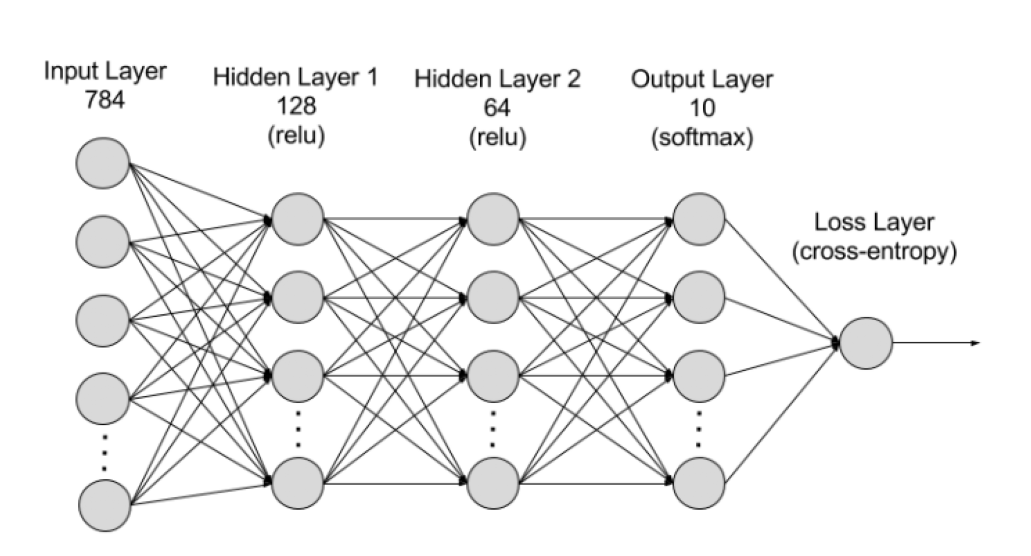

In [88]:
# Đường dẫn tới ảnh
image_path = '/content/drive/MyDrive/hand_written/nhandienchuviet/DefiningTheNeuralNetwork.png'

# Đọc ảnh
img = mpimg.imread(image_path)

# Hiển thị ảnh
plt.imshow(img)
plt.axis('off')  # Tùy chọn không hiển thị trục
plt.show()

In [89]:
import torch.optim as optim

# Layer details for the neural network
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

# Build a feed-forward network
model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.LogSoftmax(dim=1)
)
# Xác định optimizer và criterion
optimizer = optim.SGD(model.parameters(), lr=0.01)
criterion = nn.NLLLoss()

In [90]:
# Tạo một batch dữ liệu ngẫu nhiên và nhãn tương ứng
simple_input = torch.randn(64, 784, requires_grad=True)  # Giả sử batch_size là 64
simple_labels = torch.randint(0, output_size, (64,))  # Tạo nhãn ngẫu nhiên từ 0 đến 9

In [91]:
# Clear gradients (để đảm bảo gradients cũ không ảnh hưởng đến kết quả)
optimizer.zero_grad()

# Thực hiện forward pass
output = model(simple_input)

# Tính loss
loss = criterion(output, simple_labels)

# Backward pass để tính gradient
loss.backward()

In [92]:
# In ra gradient của trọng số trong lớp đầu tiên
print("Gradient of the first layer weights:\n", model[0].weight.grad)

Gradient of the first layer weights:
 tensor([[-0.0015,  0.0035,  0.0055,  ...,  0.0008, -0.0010, -0.0033],
        [-0.0014,  0.0012,  0.0005,  ..., -0.0019, -0.0014, -0.0002],
        [ 0.0024,  0.0007,  0.0020,  ...,  0.0006, -0.0014, -0.0019],
        ...,
        [ 0.0011, -0.0029,  0.0011,  ...,  0.0020, -0.0017,  0.0010],
        [ 0.0045,  0.0011,  0.0011,  ..., -0.0033, -0.0026,  0.0025],
        [ 0.0003,  0.0002,  0.0031,  ...,  0.0008, -0.0002, -0.0011]])


**Training**

In [93]:
num_epochs = 80  # Số lượng epochs
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

save_path = '/content/drive/MyDrive/hand_written/save_model'
if not os.path.exists(save_path):
    os.makedirs(save_path)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for images, labels in train_loader:  # Giả sử bạn đã có train_loader
        images = images.view(images.shape[0], -1)
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy = correct / total
    train_losses.append(total_loss / len(train_loader))
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.view(images.shape[0], -1)
            output = model(images)
            loss = criterion(output, labels)
            val_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_accuracy = correct / total
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}, Train Accuracy: {train_accuracies[-1]}, Validation Accuracy: {val_accuracies[-1]}')


    # Lưu mô hình và optimizer sau mỗi epoch
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': train_losses[-1],
        'val_loss': val_losses[-1],
        'train_accuracy': train_accuracies[-1],
        'val_accuracy': val_accuracies[-1],
    }, os.path.join(save_path, f'model_epoch_{epoch+1}.pth'))

Epoch 1/80, Train Loss: 2.1458365762801397, Validation Loss: 1.7883700312990132, Train Accuracy: 0.3388988095238095, Validation Accuracy: 0.5798809523809524
Epoch 2/80, Train Loss: 1.1635664543651398, Validation Loss: 0.7399327479528658, Train Accuracy: 0.7321428571428571, Validation Accuracy: 0.8235714285714286
Epoch 3/80, Train Loss: 0.5909795107160296, Validation Loss: 0.5031234838745811, Train Accuracy: 0.8441666666666666, Validation Accuracy: 0.8640476190476191
Epoch 4/80, Train Loss: 0.44996525792848496, Validation Loss: 0.42337796927401516, Train Accuracy: 0.8739285714285714, Validation Accuracy: 0.8829761904761905
Epoch 5/80, Train Loss: 0.3916146385669708, Validation Loss: 0.38478803487889696, Train Accuracy: 0.8882738095238095, Validation Accuracy: 0.8922619047619048
Epoch 6/80, Train Loss: 0.3580220370917093, Validation Loss: 0.35934241511153453, Train Accuracy: 0.8963988095238096, Validation Accuracy: 0.8998809523809523
Epoch 7/80, Train Loss: 0.33472451093651, Validation L

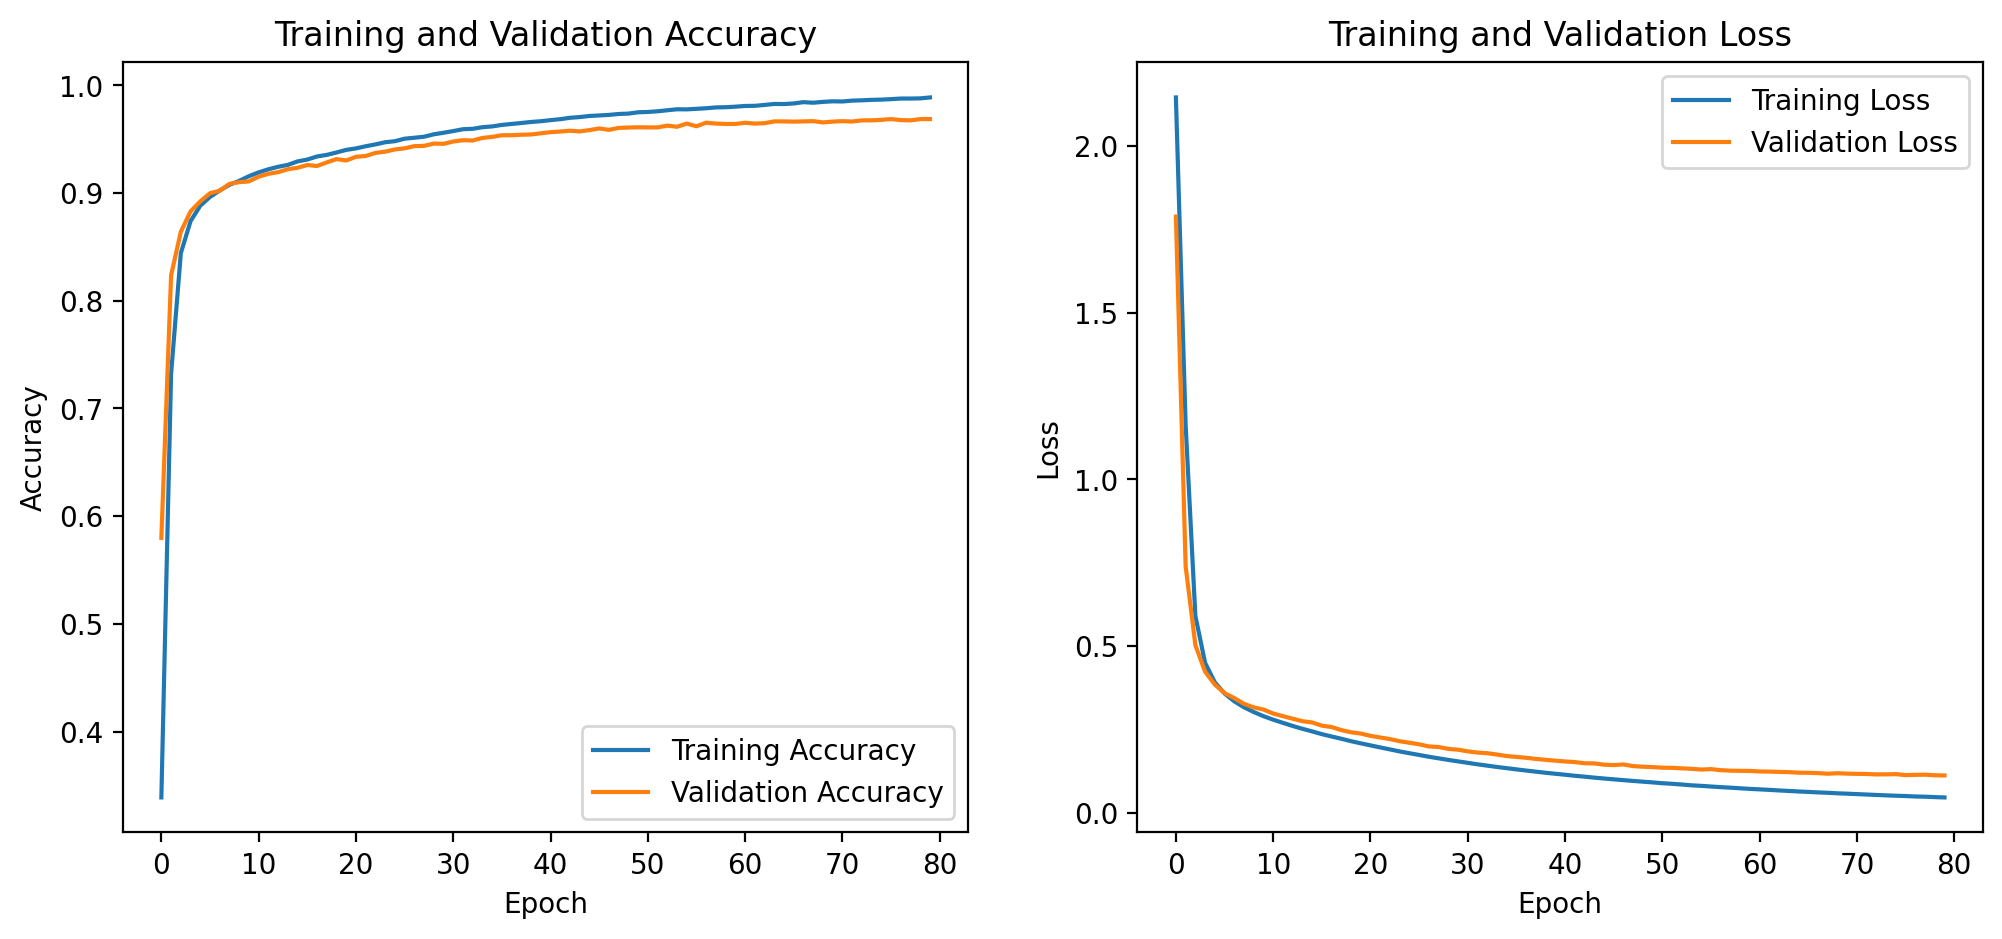

In [94]:
import matplotlib.pyplot as plt

# Vẽ đồ thị biểu diễn sự thay đổi của accuracy và loss
plt.figure(figsize=(12, 5))

# Biểu đồ Accuracy
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Biểu đồ Loss
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


**Overfitting:** Khi mô hình học quá kỹ trên tập huấn luyện, nó có thể không tổng quát hóa tốt cho dữ liệu mới. Dấu hiệu của overfitting là khi hàm mất mát trên tập kiểm tra cao hơn nhiều so với tập huấn luyện hoặc khi độ chính xác của tập kiểm tra thấp hơn nhiều so với tập huấn luyện.
Trong đồ thị này, không có dấu hiệu overfitting rõ ràng vì độ chính xác và hàm mất mát của cả tập huấn luyện và tập kiểm tra rất gần nhau.

**Underfitting:** Khi mô hình không học đủ từ dữ liệu huấn luyện, nó sẽ có hiệu suất thấp cả trên tập huấn luyện và tập kiểm tra. Dấu hiệu của underfitting là khi cả độ chính xác và hàm mất mát của tập huấn luyện đều kém.
Trong đồ thị này, không có dấu hiệu underfitting vì độ chính xác và hàm mất mát của cả tập huấn luyện và tập kiểm tra đều đạt kết quả tốt.

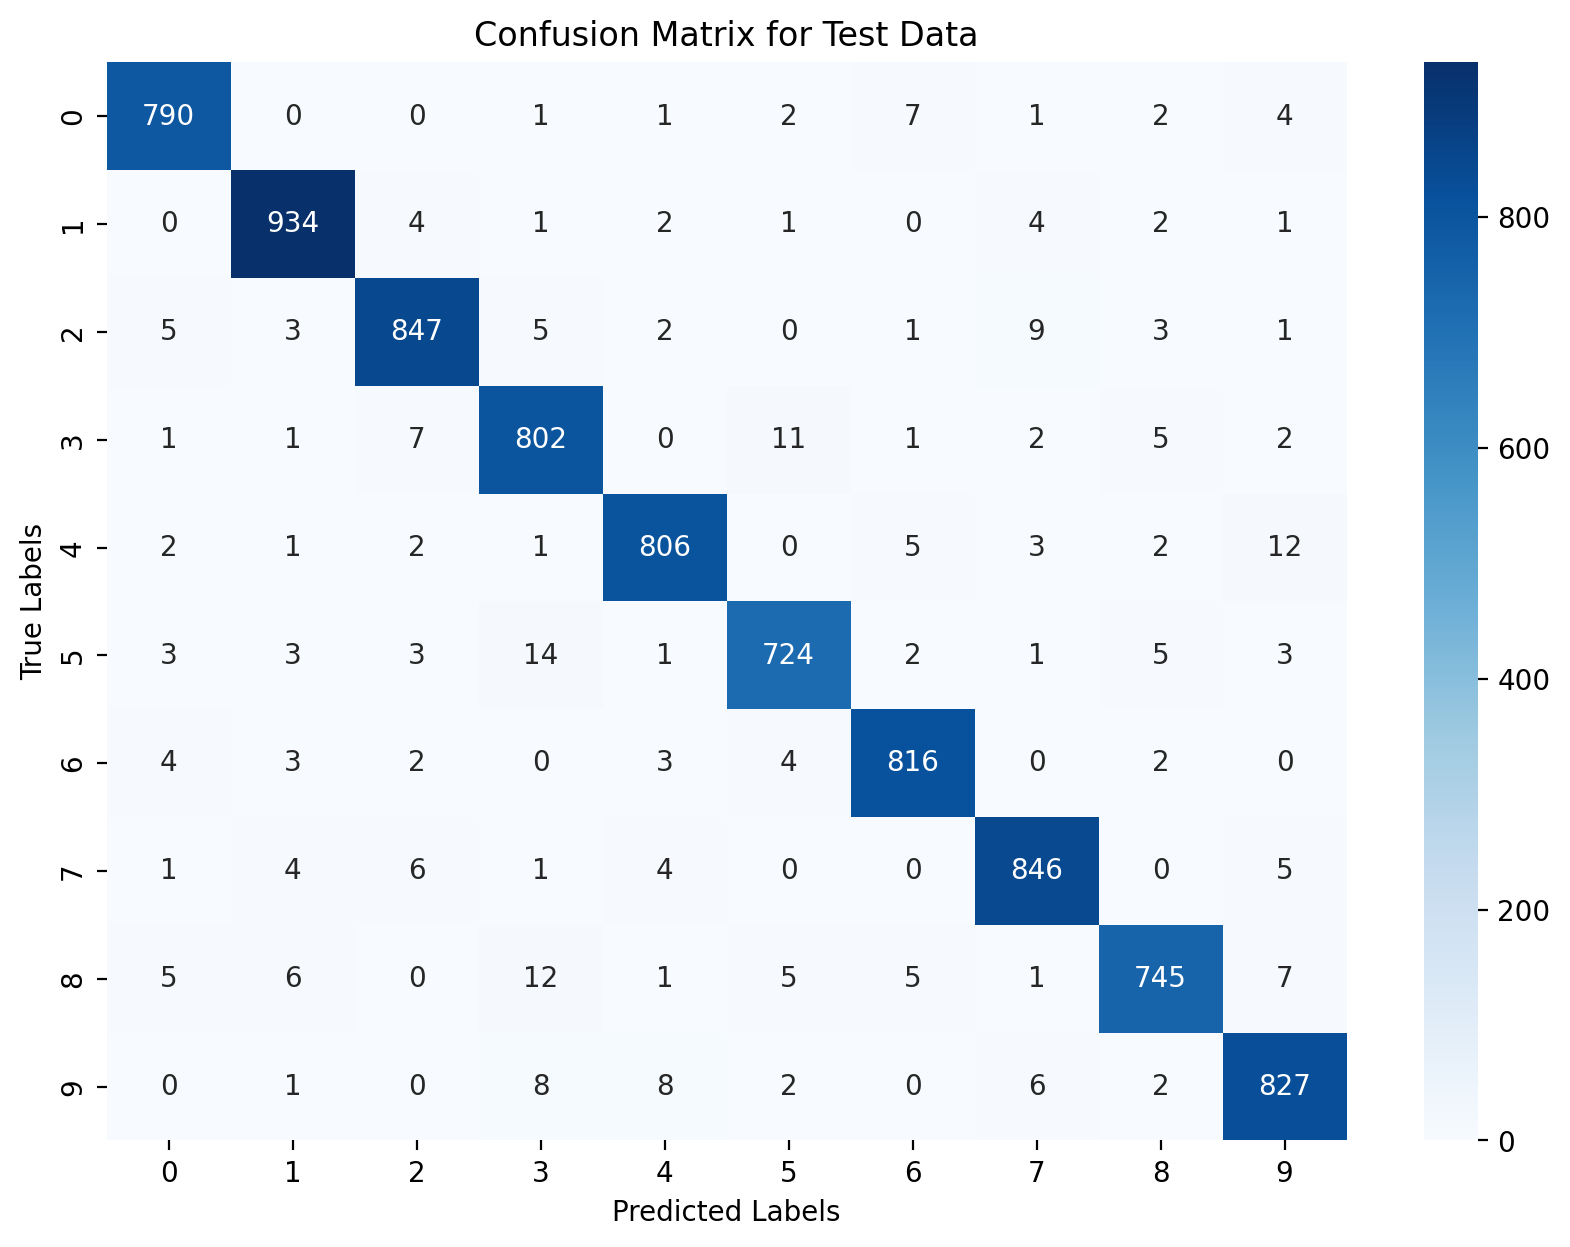

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       808
           1       0.98      0.98      0.98       949
           2       0.97      0.97      0.97       876
           3       0.95      0.96      0.96       832
           4       0.97      0.97      0.97       834
           5       0.97      0.95      0.96       759
           6       0.97      0.98      0.98       834
           7       0.97      0.98      0.97       867
           8       0.97      0.95      0.96       787
           9       0.96      0.97      0.96       854

    accuracy                           0.97      8400
   macro avg       0.97      0.97      0.97      8400
weighted avg       0.97      0.97      0.97      8400



In [96]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns


# Tính toán confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Test Data')
plt.show()

# In báo cáo đánh giá chi tiết cho tập test
print(classification_report(all_labels, all_preds))

Image 1: Predicted Digit = 2


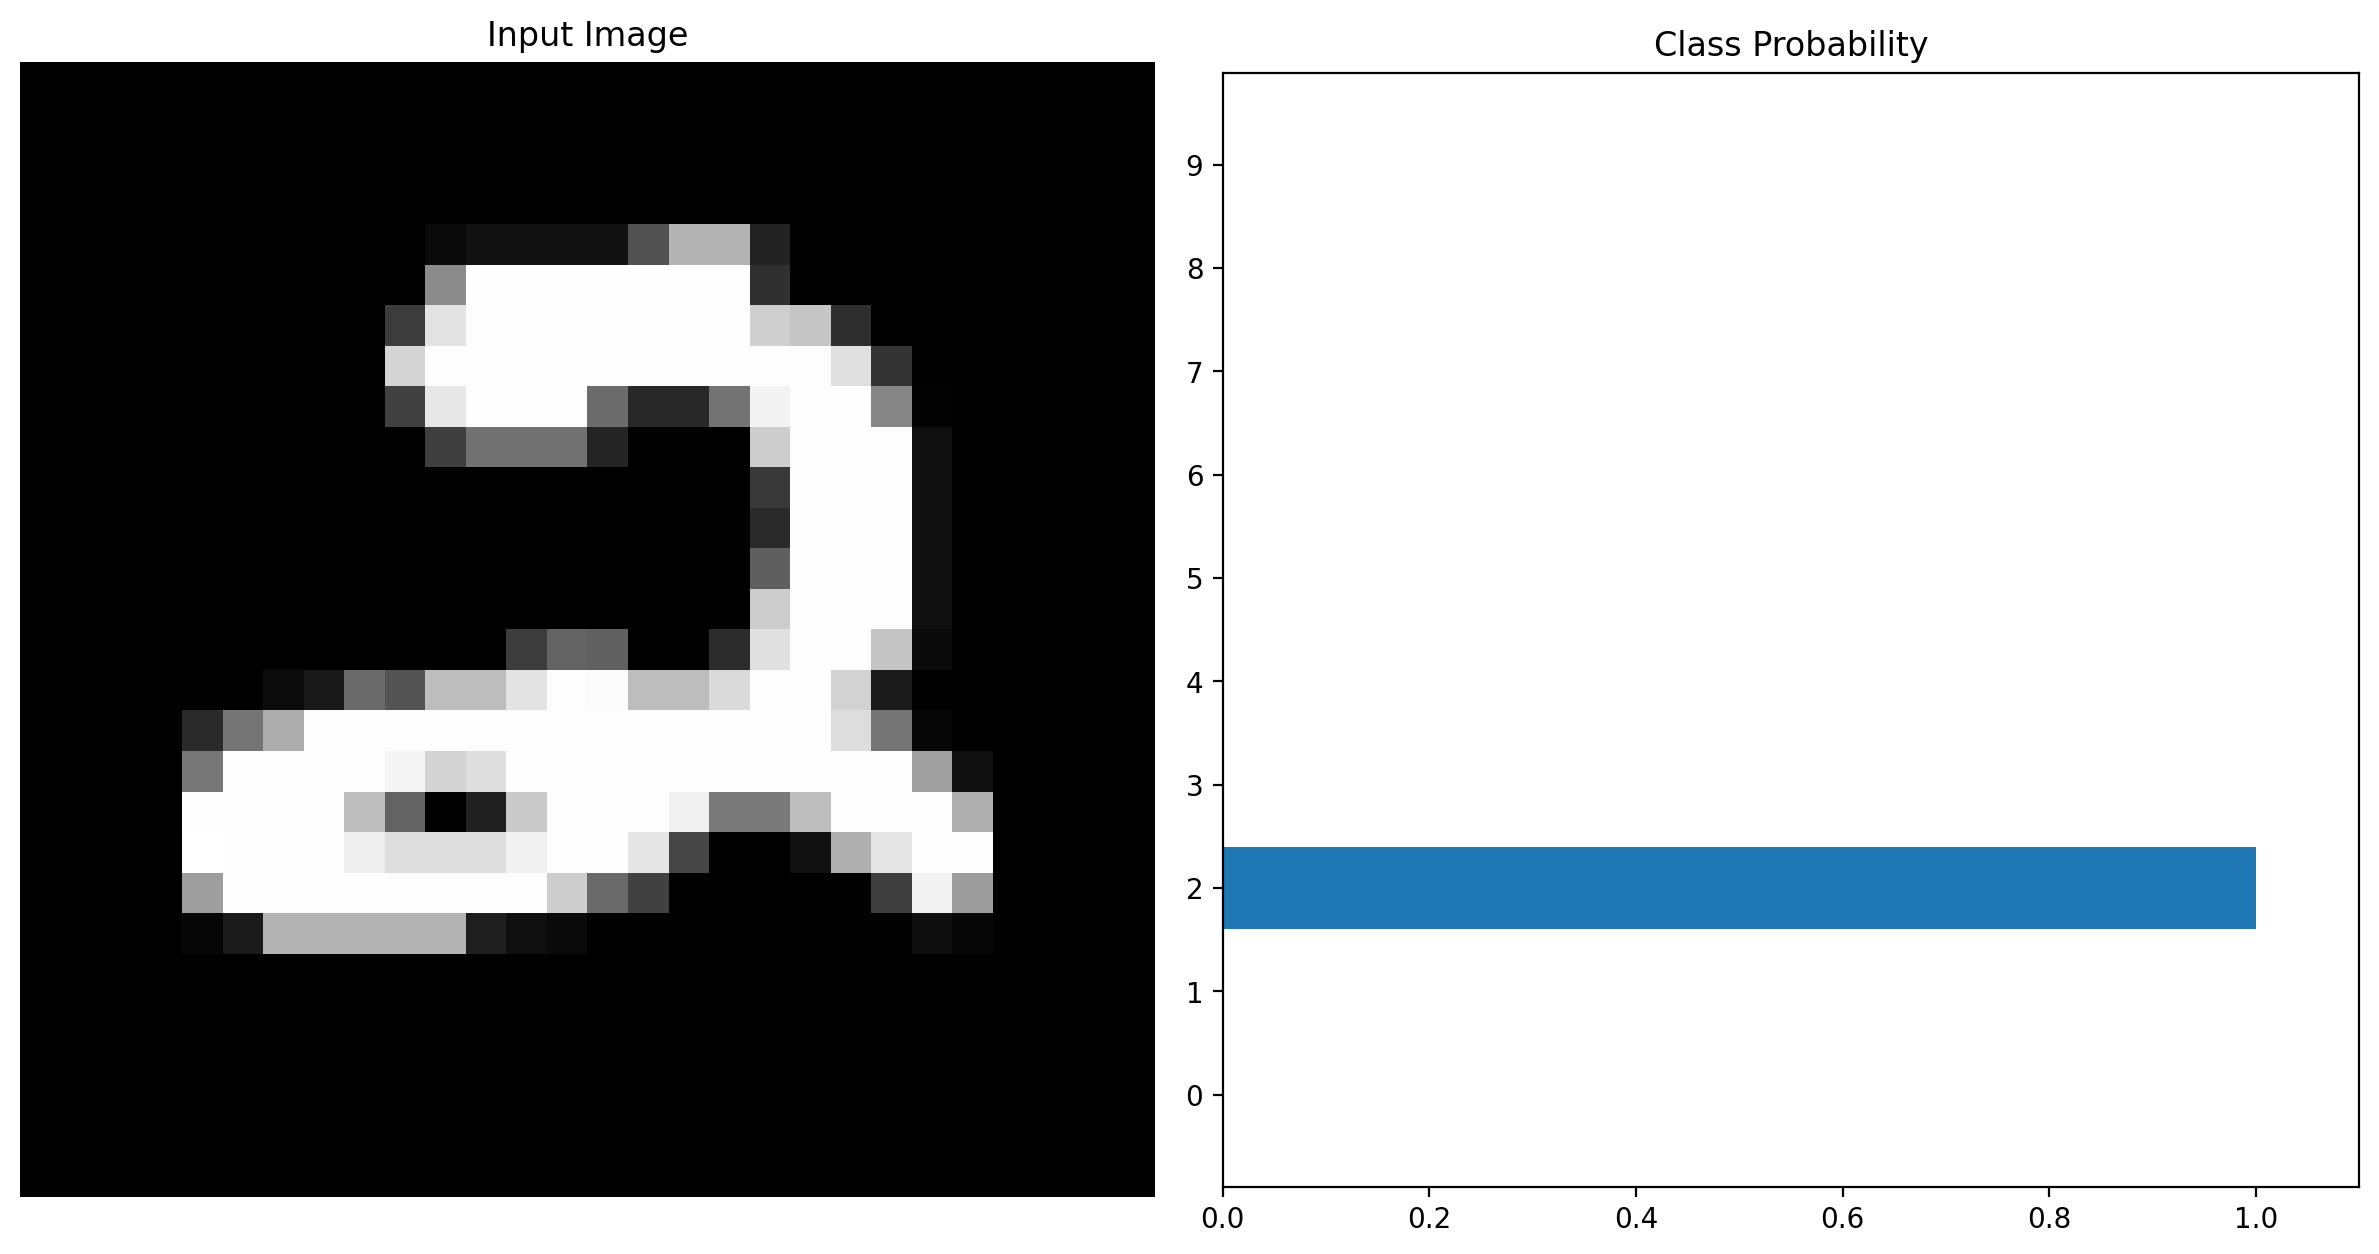

Image 2: Predicted Digit = 0


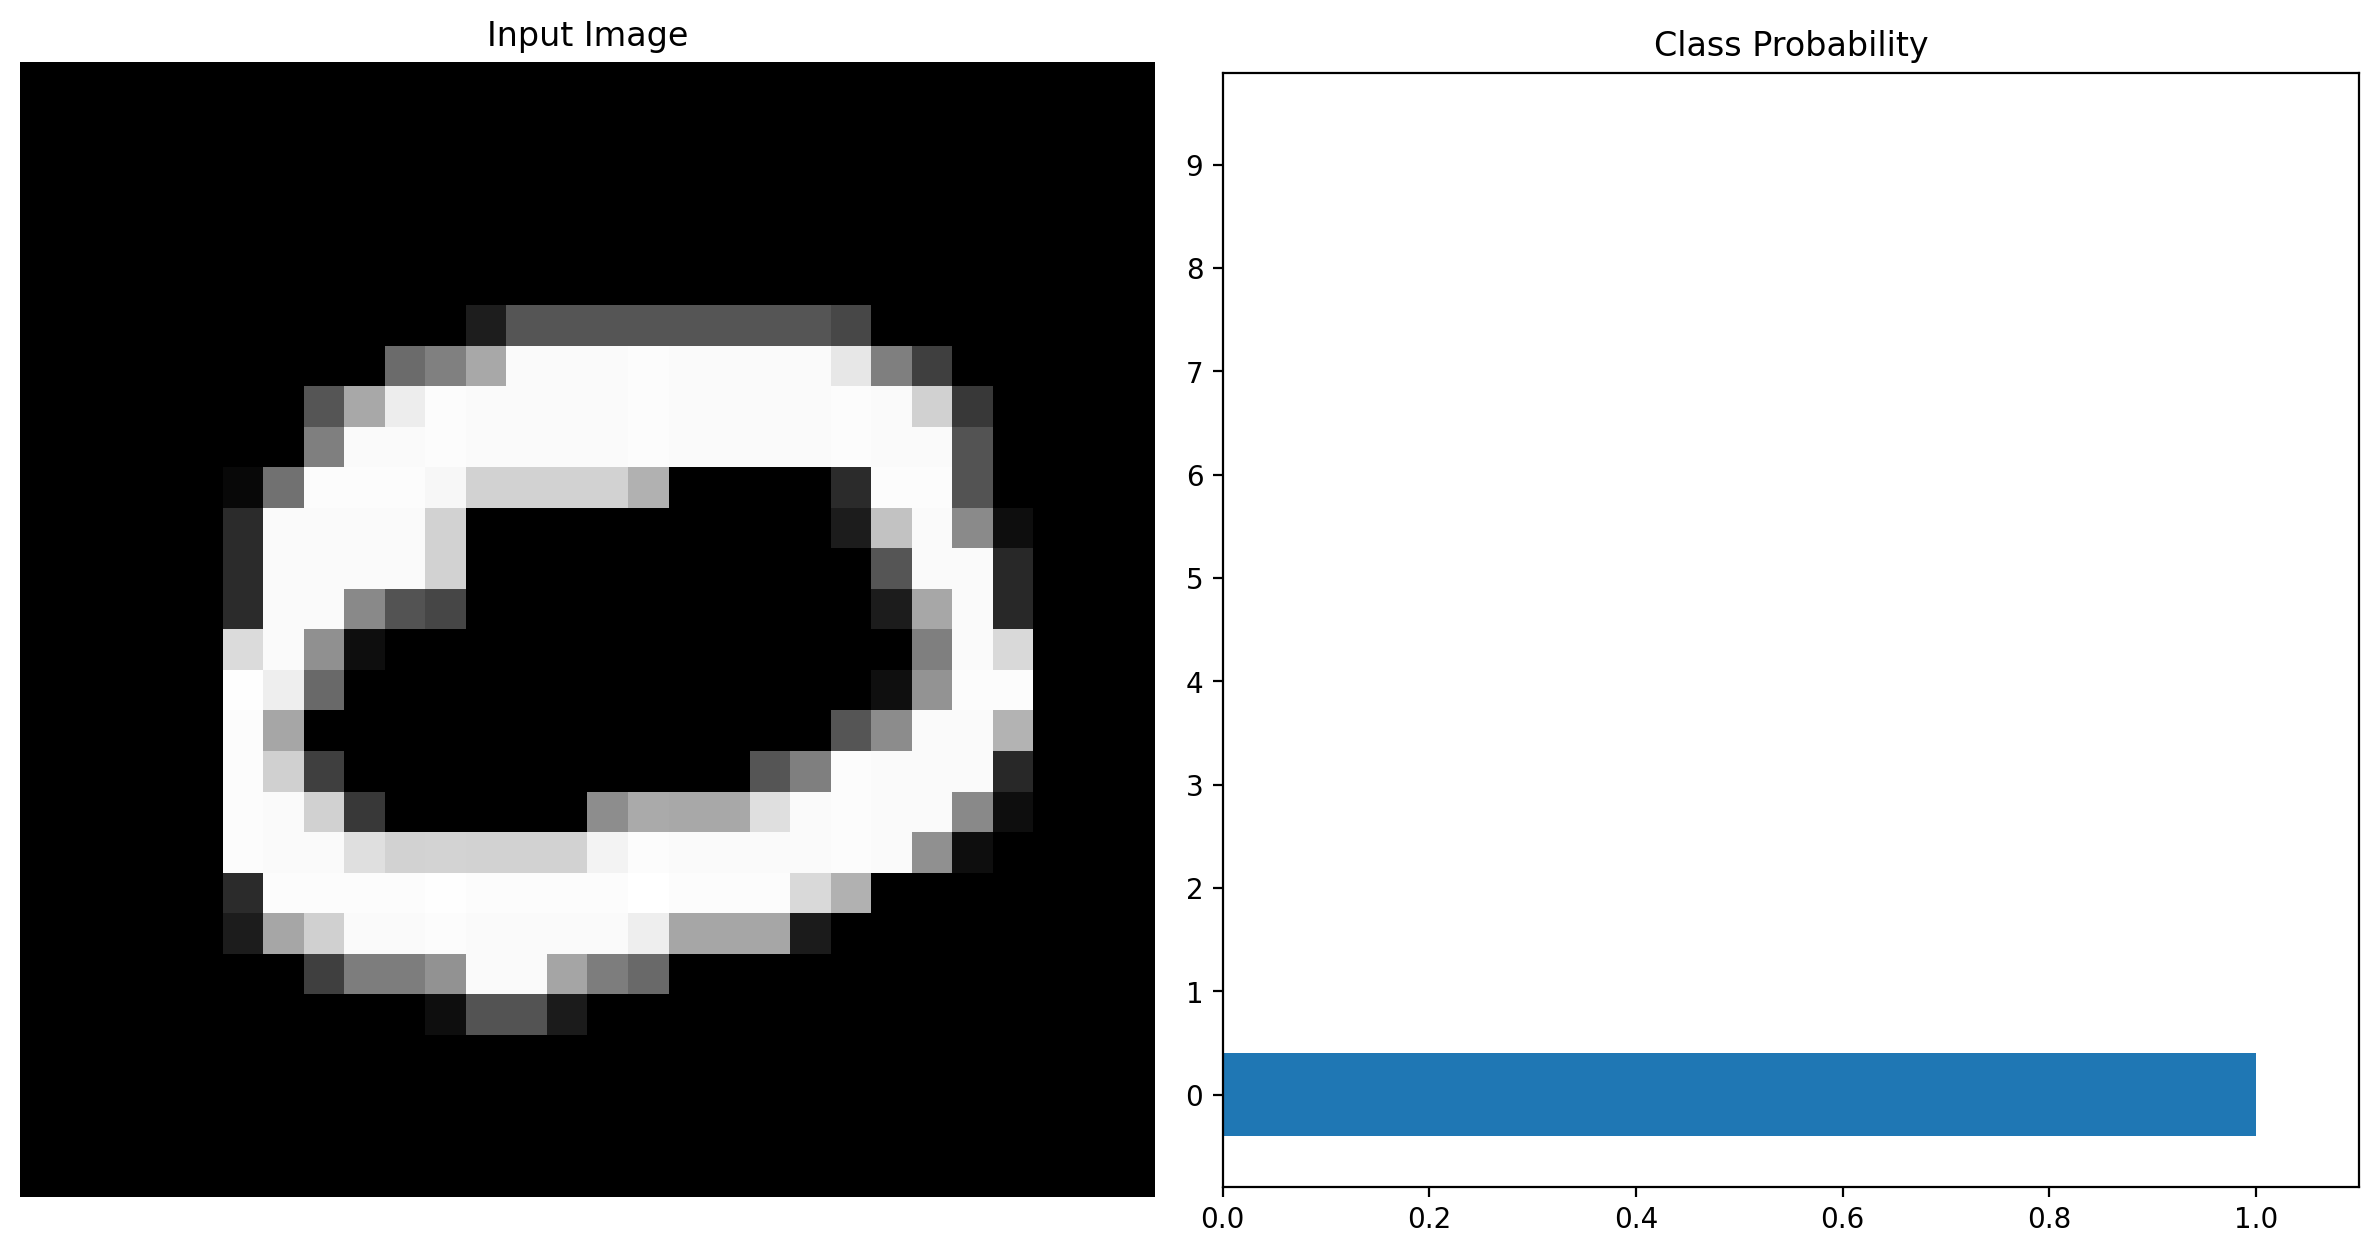

In [97]:
import torch
import matplotlib.pyplot as plt
import numpy as np



# Lấy một batch ảnh từ test_loader
batch = next(iter(test_loader))
images = batch[0]  # Lấy các ảnh từ batch

def view_classify(img, ps):
    ''' Function for viewing an image and its predicted classes.
    '''
    ps = ps.data.numpy().squeeze()
    fig, (ax1, ax2) = plt.subplots(figsize=(12, 6), ncols=2)
    ax1.imshow(img.view(28, 28).numpy().squeeze(), cmap='gray')
    ax1.axis('off')
    ax1.set_title('Input Image')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()
    plt.show()

def predict_and_display(model, images, num_samples=2):
    for i in range(num_samples):
        # Lấy một ảnh bất kỳ từ batch, ví dụ ảnh thứ i
        img = images[i].view(1, 784)

        # Turn off gradients to speed up this part
        with torch.no_grad():
            logps = model(img)

        # Output of the network are log-probabilities, need to take exponential for probabilities
        ps = torch.exp(logps)
        probab = list(ps.numpy()[0])
        print(f"Image {i+1}: Predicted Digit =", probab.index(max(probab)))

        # Hiển thị ảnh và dự đoán
        view_classify(img.view(1, 28, 28), ps)

# Ví dụ sử dụng hàm với model và batch ảnh của bạn
predict_and_display(model, images, num_samples=2)
